# import and read data

In [7]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [9]:
# define training and test data directories

train_dir = 'abuse - Copy'
test_dir = 'abuse_test - Copy'
abb = 'abb'

# classes are folders in each directory with these names
classes = ['natural', 'abuse']

# Resize

In [10]:
# load and transform data using ImageFolder
# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.CenterCrop(224), 
                                      transforms.ToTensor()])

#Image folder be3ml trasform w erg3ha png
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
abb_data = datasets.ImageFolder(abb, transform=data_transform)


# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))
print('Num test images: ', len(abb_data))


Num training images:  862
Num test images:  166
Num test images:  20


In [13]:
abb_loader = torch.utils.data.DataLoader(abb_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

# Visualize some sample data

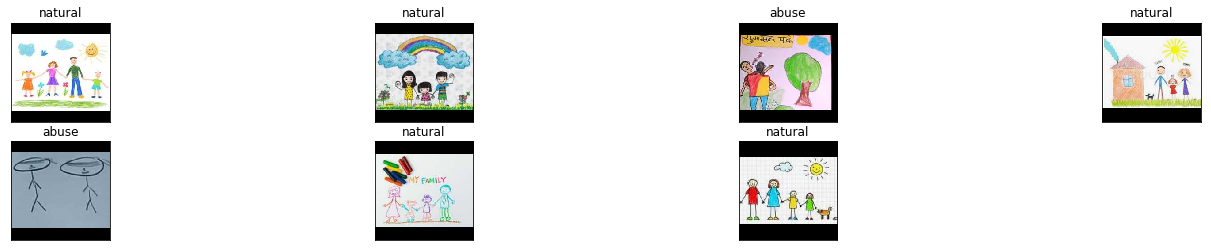

In [163]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(7):
    ax = fig.add_subplot(2, 8/2, idx+1, xticks=[], yticks=[])
    #(1,2,0) da bta3 3 D image
    plt.imshow( np.transpose(images[idx], (1, 2, 0)) )
    ax.set_title(classes[labels[idx]])

# Load the pretrained model

In [164]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
#print(vgg16)

In [165]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# last layer

In [166]:
import torch.nn as nn
## TODO: add a last linear layer  that maps n_inputs -> 5 flower classes
## new layers automatically have requires_grad = True
# get number of inputs
num_inputs = vgg16.classifier[6].in_features
classfier_layer = nn.Linear(num_inputs, len(classes))

vgg16.classifier[6] = classfier_layer


# after completing your model, if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

In [167]:
vgg16.classifier[6] 

Linear(in_features=4096, out_features=2, bias=True)

In [168]:
num_inputs

4096

# loss

In [169]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

# train

In [14]:
from sklearn.model_selection import GridSearchCV

In [170]:
n_epochs = 5
for epoch in range(1, n_epochs+1):
    train_loss = 0.0

    for batch_i, (data, target) in enumerate(train_loader):
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 0.5918224006891251
Epoch 1, Batch 40 loss: 0.4544914066791534
Epoch 2, Batch 20 loss: 0.3703309282660484
Epoch 2, Batch 40 loss: 0.3562524378299713
Epoch 3, Batch 20 loss: 0.3328624576330185
Epoch 3, Batch 40 loss: 0.3065413787961006
Epoch 4, Batch 20 loss: 0.2803935348987580
Epoch 4, Batch 40 loss: 0.3002376481890678
Epoch 5, Batch 20 loss: 0.2595110163092613
Epoch 5, Batch 40 loss: 0.2645797014236450


# test

In [171]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    
    # loss.item() : be7ol tensor l python number
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    
    # calculate test accuracy for each object class
    for i in range(2):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.420162

Test Accuracy of natural: 100% (11/11)
Test Accuracy of abuse: 71% ( 5/ 7)

Test Accuracy (Overall): 88% (16/18)


In [172]:
batch_size

20

# Display

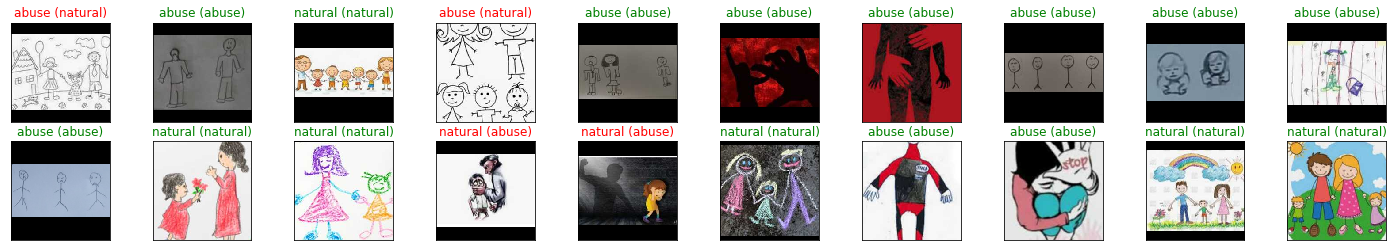

In [174]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# our img

Test Loss: 0.027603

Test Accuracy of natural: 100% ( 1/ 1)
Test Accuracy of abuse: 100% ( 1/ 1)

Test Accuracy (Overall): 100% ( 2/ 2)


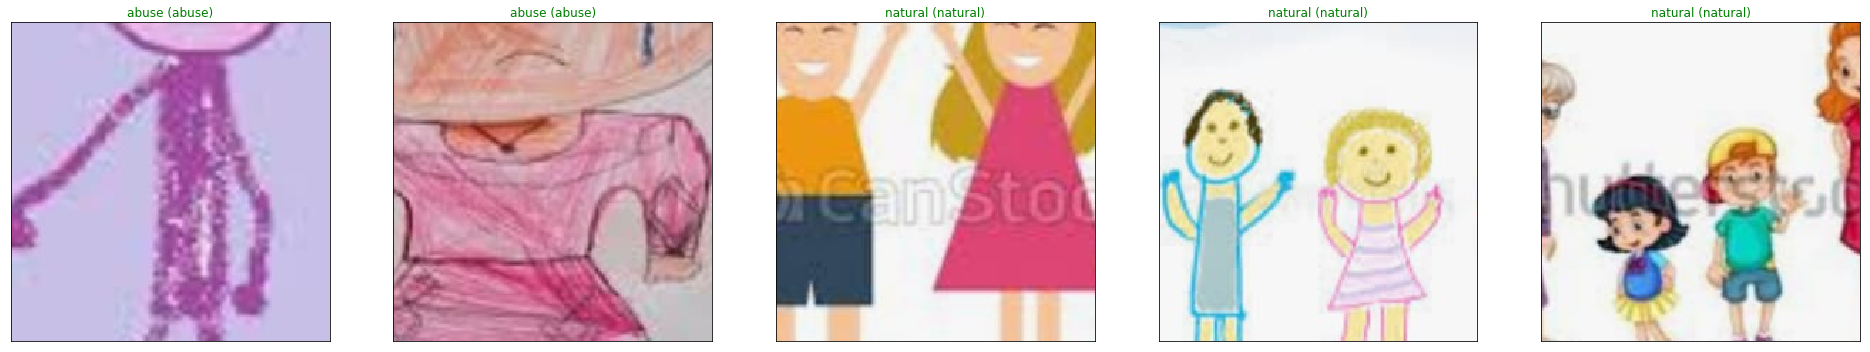

In [201]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

vgg16.eval() # eval mode

# iterate over test data
for data, target in abb_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    
    # loss.item() : be7ol tensor l python number
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    
    # calculate test accuracy for each object class
    for i in range(2):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# obtain one batch of test images
dataiter = iter(abb_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch , along with predicted and true labels
fig = plt.figure(figsize=(40, 70))
for idx in np.arange(5):
    ax = fig.add_subplot(5, 30/5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

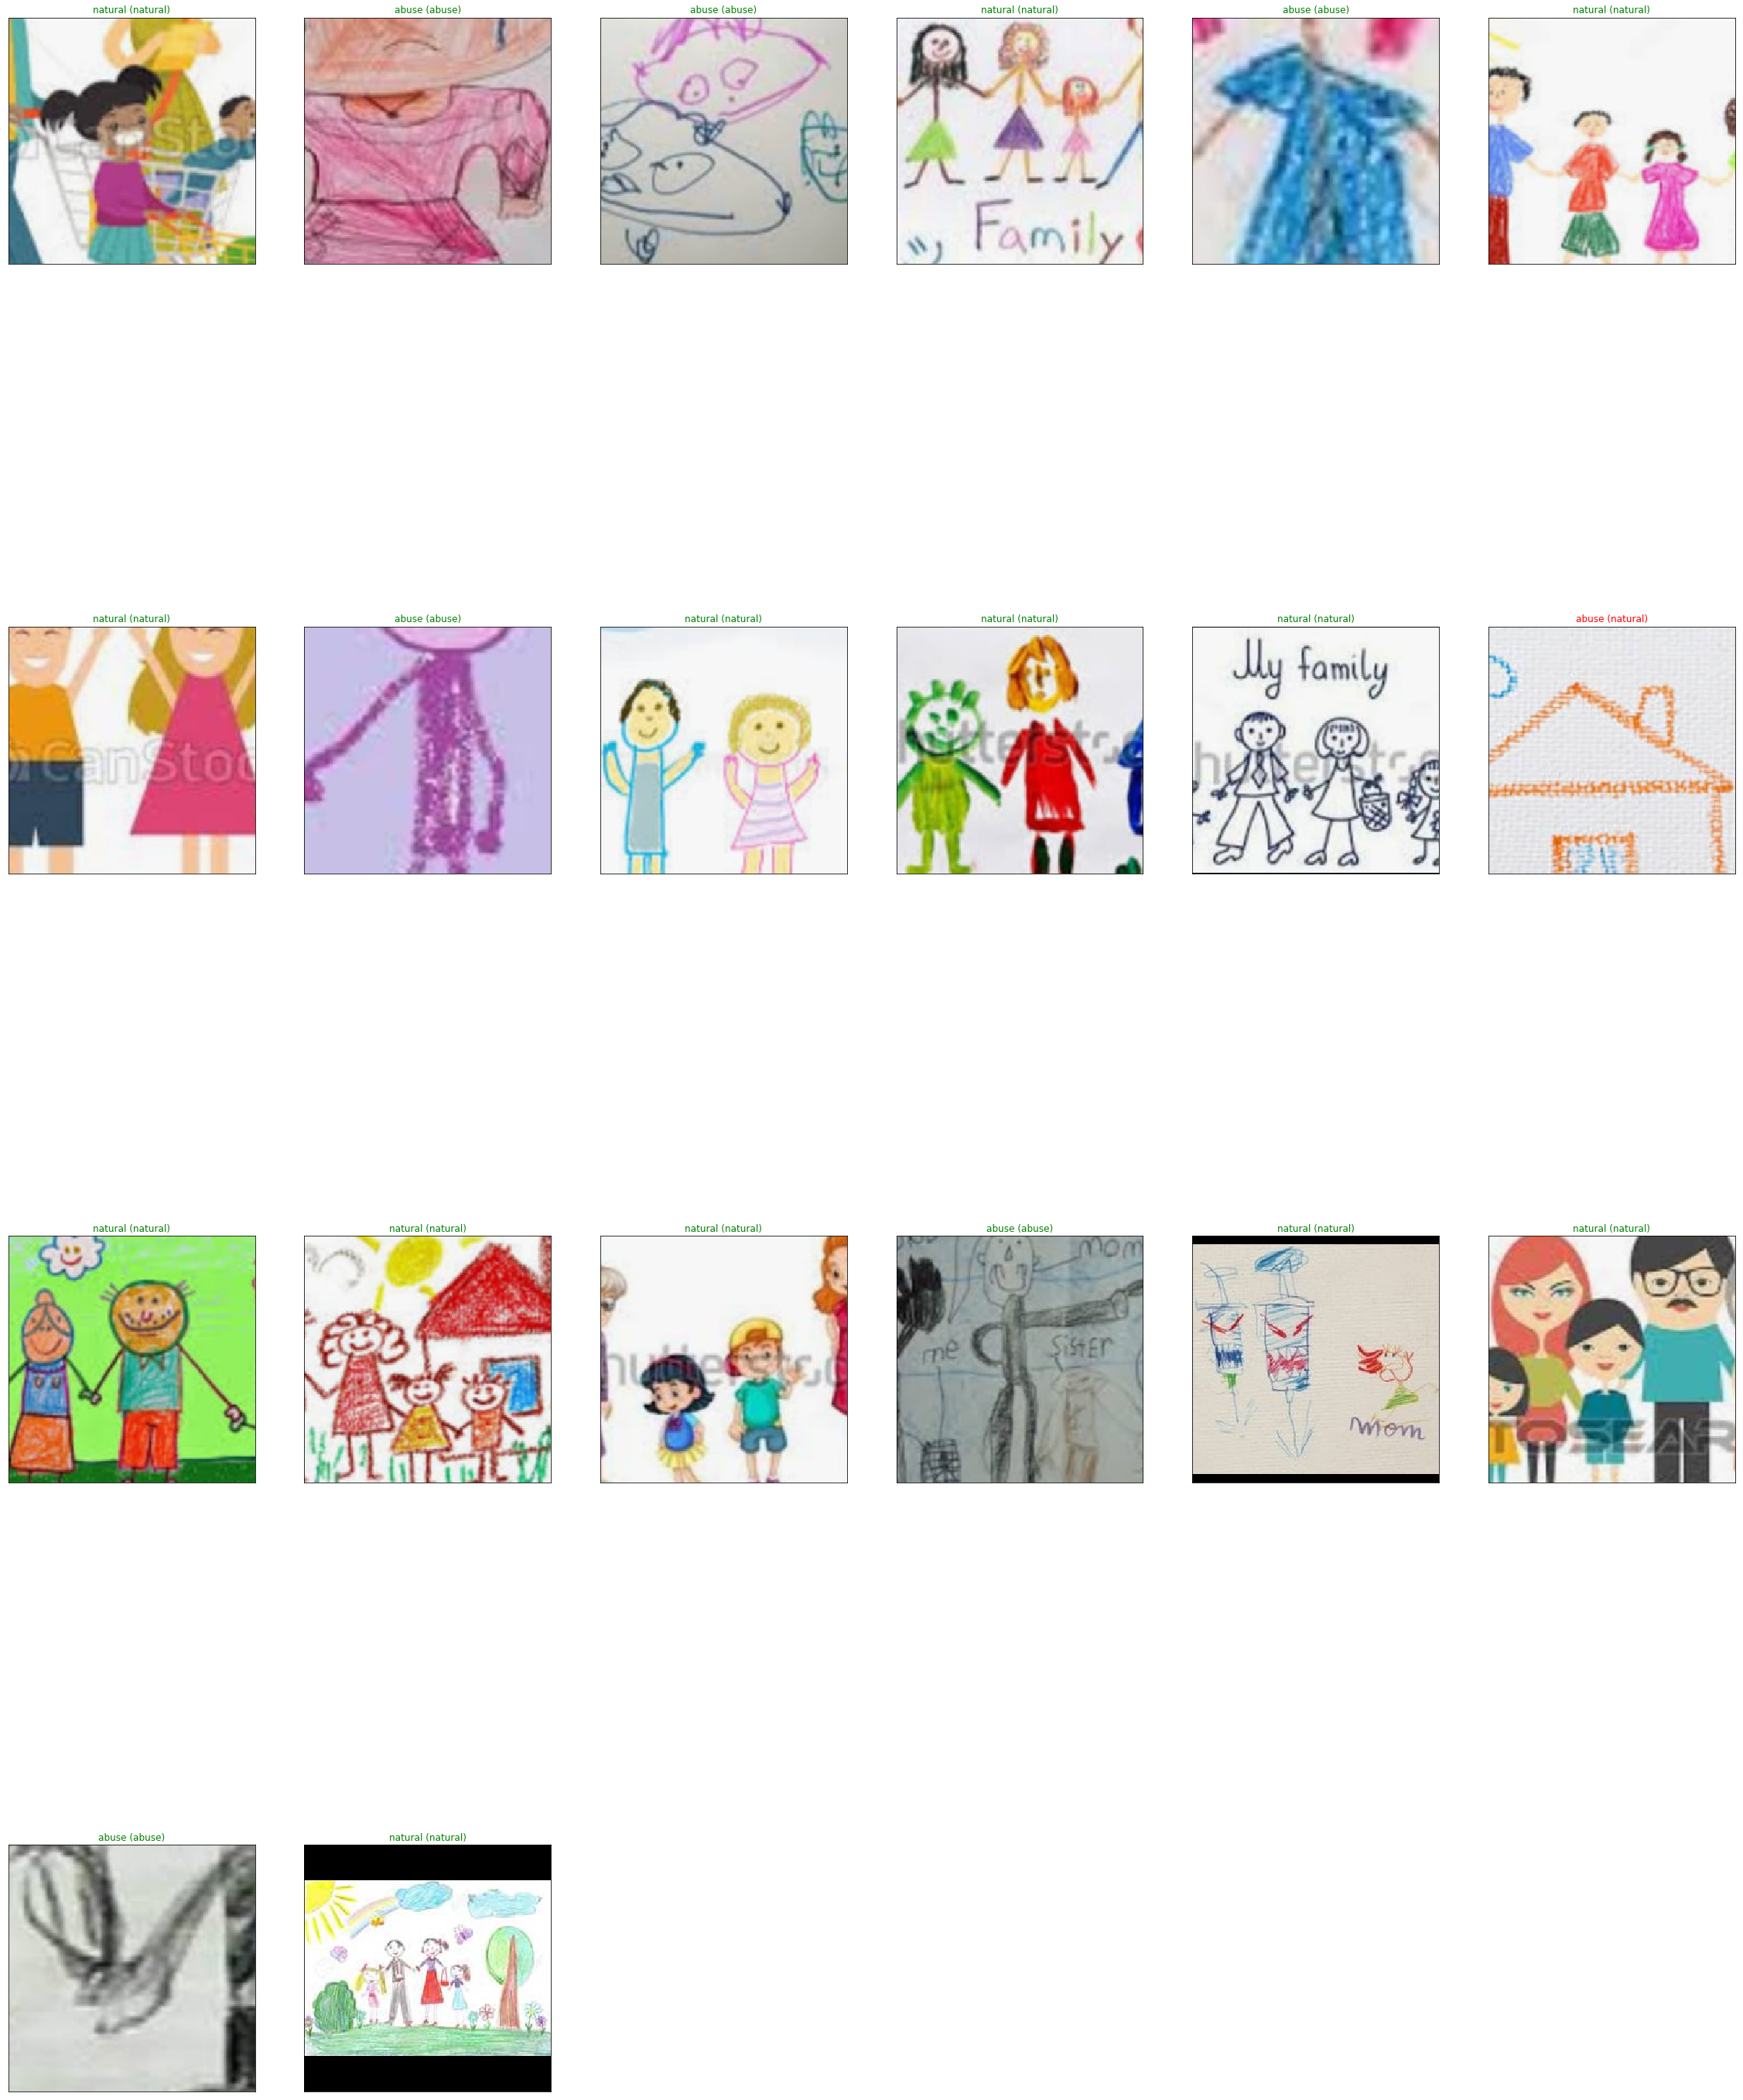

In [202]:
# obtain one batch of test images
dataiter = iter(abb_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch , along with predicted and true labels
fig = plt.figure(figsize=(40, 70))
for idx in np.arange(20):
    ax = fig.add_subplot(5, 30/5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))